###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `1255309`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
# The code for Naive Bayes are adapted from Week 3 workshops
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
def preprocess(trainfile, testfile):
    train_df = pd.read_csv(trainfile)
    test_df = pd.read_csv(testfile)
    return train_df, test_df

In [2]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing
def preprocess(trainfile, testfile):
    train_df = pd.read_csv(trainfile)
    test_df = pd.read_csv(testfile)
    return train_df, test_df

In [3]:
def gaussian_pdf(value, mean, sd):
    '''
    gaussian probability density function
    '''
    return (1 / (sd * np.sqrt(2 * np.pi))) * np.exp((-1/2) * ((value - mean) ** 2 / sd ** 2))


In [4]:
def calc_prior(data):
    '''
    calculate the prior probability for data
    '''

    prior_prob = {}

    labels = data.values[:, -1]
    n = len(labels)
    unique_labels, counts = np.unique(labels, return_counts = True)
    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (counts[i] / n).round(2)
    return prior_prob    

In [5]:
def calc_likelihood(data):
    '''
    record the mean and standard deviation for data for calculating posterior probability
    '''
    likelihood = {}
    unique_labels = np.unique(data.values[:, -1])
    featurs_list = data.columns[1:-1]
    
    for feature in featurs_list:

        likelihood[feature] = {}

        for label in unique_labels:
            likelihood[feature][label] = {}
            
            # extract the data and calculate the mean and standard deviation
            feature_label_values = (data.loc[data['label'] == label].loc[:, feature]).tolist()
            mean = np.mean(feature_label_values)
            std = np.std(feature_label_values)
            likelihood[feature][label]['mean'] = mean
            likelihood[feature][label]['std'] = std

    return likelihood

In [6]:
def calc_posterior(data, prior_prob, likelihood):
    '''
    calculate the posterior probability
    '''
    posterior_probs = []
    for _, instance in data.iterrows():
        post_probs = {}
        for label in prior_prob:
            post_probs[label] = np.log(prior_prob[label])
            for feature in likelihood.keys():
                value = instance[feature]
                mean = likelihood[feature][label]['mean']
                std = likelihood[feature][label]['std']
                density = gaussian_pdf(value, mean, std)

                # if the density is to small, replace it with log(1e-8)
                if (density == 0) or (np.isnan(value)):
                    post_probs[label] += np.log(1e-8)
                else:
                    post_probs[label] += np.log(density)

        posterior_probs.append(post_probs)
    return posterior_probs

            

    

In [7]:
def train(data):
    '''
    calculate the prior probabilities and likelihoods
    '''
    prior_prob = calc_prior(data)
    likelihood = calc_likelihood(data)
    return prior_prob, likelihood

In [8]:
def predict(data, prior_prob, likelihood):
    '''
    predict the label
    '''

    # calculate posterior probabilities
    posterior_probs = calc_posterior(data, prior_prob, likelihood)

    # find argmax
    argmax_labels = []
    for post_prob in posterior_probs:
        max_prob = -10000000
        max_label = None
        for label in post_prob:
            if label in prior_prob:
                prob = post_prob[label]
                if prob > max_prob:
                    max_prob = prob
                    max_label = label

        if max_label is not None:
            argmax_labels.append(max_label)
    return argmax_labels

In [9]:
def evaluate(predictions, true_labels, positive_label):
    ''' 
    calcuate accuracy, precision and recall
    '''

    correct = 0
    tp = 0
    fp = 0
    fn = 0
    total = len(predictions)
    for i in range(total):
        if predictions[i] == true_labels[i]:
            correct += 1
        if true_labels[i] == positive_label:
            if predictions[i] == true_labels[i]:
                tp += 1
            else:
                fn += 1
        else:
            if predictions[i] == positive_label:
                fp += 1
    accuracy = correct / total
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return accuracy, precision, recall

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [10]:
train_df, test_df = preprocess('COMP30027_2023_asst1_data/pop_vs_classical_train.csv', 'COMP30027_2023_asst1_data/pop_vs_classical_test.csv')
prior_prob, likelihood = train(train_df)
posterior_probs = calc_posterior(train_df, prior_prob, likelihood)
predictions = predict(test_df, prior_prob, likelihood)
true_labels = test_df['label'].tolist()
accuracy, precision, recall = evaluate(predictions, true_labels, 'classical')
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.9767441860465116
Precision:  0.9523809523809523
Recall:  1.0


### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

In [11]:
# extracting the likelihood of features
spectra_centroid_mean = likelihood['spectral_centroid_mean']
harmony_mean = likelihood['harmony_mean']
tempo = likelihood['tempo']

In [12]:
def plot(feature, likelihood):
    ''' 
    plot the probability density
    '''
    feature_info = likelihood[feature]
    feature_classical_mean = feature_info['classical']['mean']
    feature_classical_std = feature_info['classical']['std']
    feature_pop_mean = feature_info['pop']['mean']
    feature_pop_std = feature_info['pop']['std']
    classical_x = []
    classical_y = []
    pop_x = []
    pop_y = []

    # the range is (mean - 3 * std, mean + 3 * std)
    classical_x_min = feature_classical_mean - 3 * feature_classical_std
    classical_x_max = feature_classical_mean + 3 * feature_classical_std
    pop_x_min = feature_pop_mean - 3 * feature_pop_std
    pop_x_max = feature_pop_mean + 3 * feature_pop_std
    points_num = 10000
    classical_step_size = (classical_x_max - classical_x_min) / points_num
    pop_step_size = (pop_x_max - pop_x_min) / points_num

    # create the data for plotting
    for i in range(points_num):
        classical_value = classical_x_min + i * classical_step_size
        pop_value = pop_x_min + i * pop_step_size
        classical_x.append(classical_value)
        classical_y.append(gaussian_pdf(classical_value, feature_classical_mean, feature_classical_std))
        pop_x.append(pop_value)
        pop_y.append(gaussian_pdf(pop_value, feature_pop_mean, feature_pop_std))
    
    # plot
    plt.plot(classical_x, classical_y, label = 'classical')
    plt.plot(pop_x, pop_y, label = 'pop')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Probabiblity Density')
    plt.title(feature)
    plt.show()

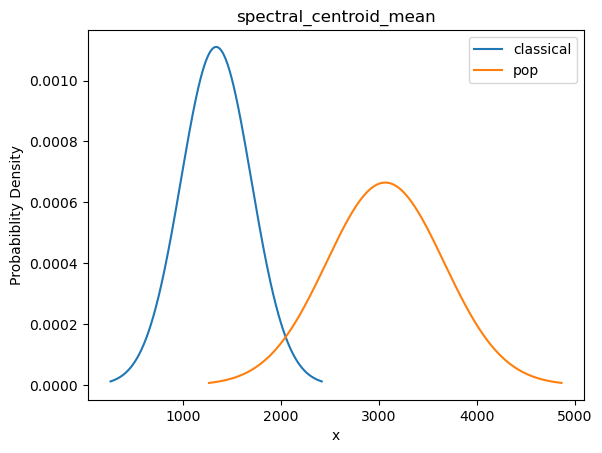

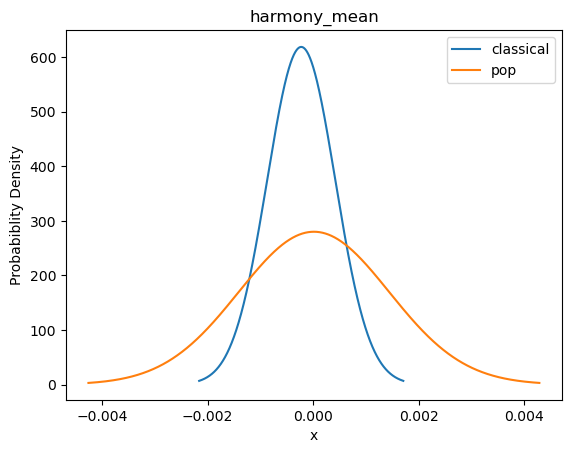

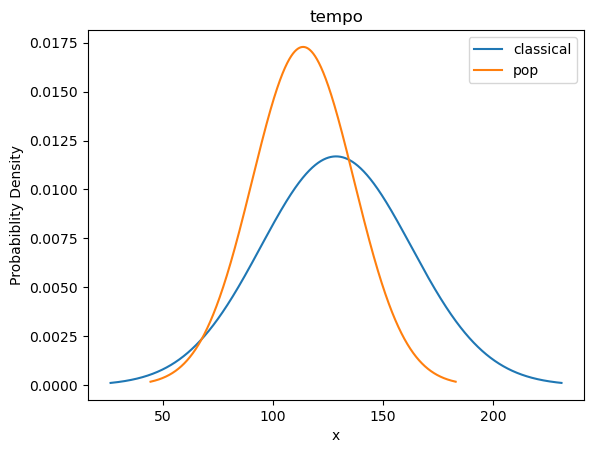

In [13]:
plot('spectral_centroid_mean', likelihood)
plot('harmony_mean', likelihood)
plot('tempo', likelihood)

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

In [14]:
# Gaussian naive Bayes model for gztan dataset
train_df, test_df = preprocess('COMP30027_2023_asst1_data/gztan_train.csv', 'COMP30027_2023_asst1_data/gztan_test.csv')
prior_prob, likelihood = train(train_df)
posterior_probs = calc_posterior(train_df, prior_prob, likelihood)
predictions = predict(test_df, prior_prob, likelihood)
true_labels = test_df['label'].tolist()
accuracy, precision, recall = evaluate(predictions, true_labels, 'classical')
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.495
Precision:  0.8947368421052632
Recall:  0.85


In [15]:
def scott_bandwidth(data):
    """
    Calculates the bandwidth for kernel density estimation using the Scott's rule.
    """
    n, d = np.shape(data)
    sigma = np.std(data)
    bw = n**(-1/(d+4)) * sigma
    return bw

In [16]:
def calc_likelihood_kde(data, bw):
    ''' 
    calculate the likelihood using the provided bandwidth and kde
    '''
    likelihood = {}
    unique_labels = np.unique(data.values[:, -1])
    featurs_list = data.columns[1:-1]
    
    for feature in featurs_list:

        likelihood[feature] = {}

        for label in unique_labels:
            likelihood[feature][label] = {}
            
            feature_label_values = (data.loc[data['label'] == label].loc[:, feature]).tolist()
            reshapped_values = np.array([[i] for i in feature_label_values])
            bandwidth = scott_bandwidth(reshapped_values)

            # compute the likelihood using kde
            if bw is not None:
                kernel_density = KernelDensity(kernel='gaussian', bandwidth=bw)
            else:
                kernel_density = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
            likelihood[feature][label] = kernel_density.fit(reshapped_values)

    return likelihood

In [17]:
def calc_posterior_kde(data, prior_prob, likelihood):
    ''' 
    calculate the posterior probability using kde
    '''
    posterior_probs = []
    for _, instance in data.iterrows():
        post_probs = {}
        for label in prior_prob:
            post_probs[label] = np.log(prior_prob[label])
            for feature in likelihood.keys():
                value =np.array([[instance[feature]]])
                pdf = likelihood[feature][label]
                density = pdf.score_samples(value)
                if (density == 0) or (np.isnan(value)):
                    post_probs[label] += np.log(1e-8)
                else:
                    # the density calculated by sklearn is already being taken log()
                    post_probs[label] += density

        posterior_probs.append(post_probs)
    return posterior_probs

In [18]:
def kde_predict(data, prior_prob, likelihood):
    ''' 
    predict the label using kde
    '''
    posterior_probs = calc_posterior_kde(data, prior_prob, likelihood)
    
    argmax_labels = []
    for post_prob in posterior_probs:
        max_prob = -10000000
        max_label = None
        for label in post_prob:
            if label in prior_prob:
                prob = post_prob[label]
                if prob > max_prob:
                    max_prob = prob
                    max_label = label

        if max_label is not None:
            argmax_labels.append(max_label)
    return argmax_labels

In [19]:
def train_kde(data, bw):
    prior_prob = calc_prior(data)
    likelihood = calc_likelihood_kde(data, bw)
    return prior_prob, likelihood

In [20]:
train_df, test_df = preprocess('COMP30027_2023_asst1_data/gztan_train.csv', 'COMP30027_2023_asst1_data/gztan_test.csv')
# sklearn has two built in bandwidth, 'scott' and 'silverman'
bandwidth = ['scott', 'silverman', None]

# compare the built-in bandwidth with scott factor
for bw in bandwidth:
    prior_prob, likelihood = train_kde(train_df, bw)
    posterior_probs = calc_posterior_kde(train_df, prior_prob, likelihood)
    predictions = kde_predict(test_df, prior_prob, likelihood)
    true_labels = test_df['label'].tolist()
    accuracy, precision, recall = evaluate(predictions, true_labels, 'classical')
    if bw is None:
        print("Scott factor")
    else:
        print(bw)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)

scott
Accuracy:  0.21052631578947367
Precision:  0.42857142857142855
Recall:  0.3157894736842105
silverman
Accuracy:  0.1951219512195122
Precision:  0.42857142857142855
Recall:  0.3
Scott factor
Accuracy:  0.56
Precision:  0.9
Recall:  0.9


### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.